In [32]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
import fiona 
import seaborn as sns
from scipy.stats import pearsonr

Data Visualisation (by Stefanie)
----

In [10]:
# Reading in the joined data table
df_joineddata = pd.read_csv(r'cleaning_data\joined_data.csv')

# Converting Linestring object to geometry again
df_joineddata['route_linestring'] = gpd.GeoSeries.from_wkt(df_joineddata['route_linestring'])
df_joineddata = gpd.GeoDataFrame(df_joineddata, geometry='route_linestring')
df_joineddata.set_crs('epsg:3857', inplace=True) # harmonising the CRS (epsg:3857 is also used by OSM and GoogleMaps)
df_joineddata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,viewpoint,Müggeleck,0.000138
1,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,bench,NaN,0.000551
2,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,bench,NaN,0.000122
3,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,bench,NaN,0.000110
4,113043,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,bench,NaN,0.000319


Geo Plotting routes data onto map of Berlin
-----

In [11]:
# Creating a child gdf from gdf_joineddata, that contains each occuring linestring only once
gdf_routesunique = df_joineddata.drop_duplicates(subset = ['route_linestring'])

In [12]:
# Reading in a shapefile of post codes in Germany and a csv with post codes corresponding to cities and then filtering for Berlin
plz_shape_df = gpd.read_file(r'data_visualisation\plz-5stellig.shp', dtype={'plz': str}) # reading in shapefile for post code areas
plz_region_df = pd.read_csv(r'data_visualisation\zuordnung_plz_ort.csv', sep=',', dtype={'plz': str}) # reading in post code csv
germany_df = pd.merge(left=plz_shape_df, right=plz_region_df, on='plz', how='inner') # joining on same post code
berlin_df = germany_df.query('ort == "Berlin"') # filtering for Berlin
gdf_berlin = gpd.GeoDataFrame(berlin_df) # converting it into a gdf
gdf_berlin.set_crs('epsg:3857', allow_override=True, inplace=True) # harmonising the CRS (epsg:3857 is also used by OSM and GoogleMaps)

,einwohner,note,plz,qkm,geometry,osm_id,ort,bundesland
1082,20313,10115 Berlin Mitte,10115,2.378466,"POLYGON ((13.366 52.536, 13.368 52.537, 13.369...",62422,Berlin,Berlin
1083,12217,10117 Berlin Mitte,10117,3.405881,"POLYGON ((13.374 52.528, 13.374 52.528, 13.375...",62422,Berlin,Berlin
1084,16363,10119 Berlin Mitte,10119,0.977302,"POLYGON ((13.401 52.536, 13.401 52.536, 13.402...",62422,Berlin,Berlin
1085,12167,10178 Berlin Mitte,10178,1.858479,"POLYGON ((13.395 52.524, 13.396 52.524, 13.396...",62422,Berlin,Berlin
1086,18664,10179 Berlin Mitte,10179,2.177671,"POLYGON ((13.403 52.512, 13.405 52.513, 13.405...",62422,Berlin,Berlin
...,...,...,...,...,...,...,...,...
1268,17274,14169 Berlin Zehlendorf,14169,5.098318,"POLYGON ((13.238 52.469, 13.253 52.467, 13.253...",62422,Berlin,Berlin
1269,15505,14193 Berlin Grunewald,14193,20.738295,"POLYGON ((13.192 52.499, 13.195 52.500, 13.199...",62422,Berlin,Berlin
1270,14667,14195 Berlin Dahlem,14195,8.087311,"POLYGON ((13.279 52.475, 13.279 52.475, 13.280...",62422,Berlin,Berlin
1271,17889,14197 Berlin Wilmersdorf,14197,1.587460,"POLYGON ((13.311 52.481, 13.312 52.480, 13.312...",62422,Berlin,Berlin


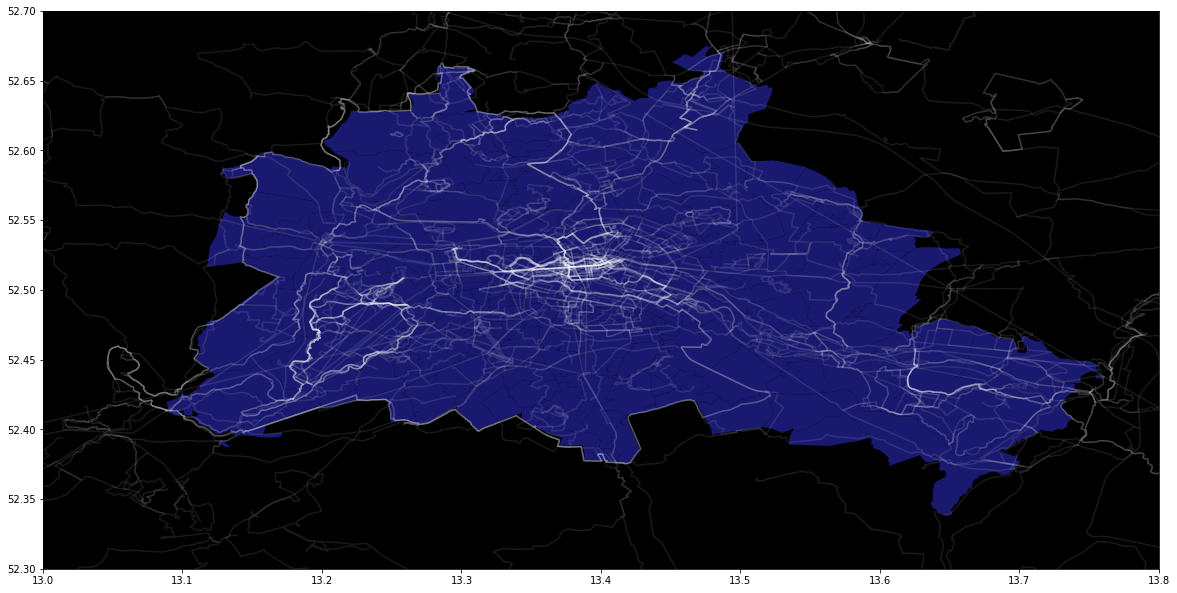

In [13]:
# Printing routes onto map of Berlin
fig, ax = plt.subplots(figsize=(20,12))
gdf_berlin.plot(ax=ax, color='midnightblue')
gdf_routesunique.plot(ax=ax, color='white', alpha=0.1)
ax.set_xlim(13.0, 13.8) # restricting the shown longitudes
ax.set_ylim(52.3, 52.7) # restricting the shown latitudes
ax.set_facecolor('black') # setting background color #darkslategrey

The geo plotting visualisation gives us intuitive insights on where our popular routes are located in Berlin. We can see clusters (thicker lines) near the touristic centres, Grunewald and Berliner Mauerweg.

(52.5, 52.53)

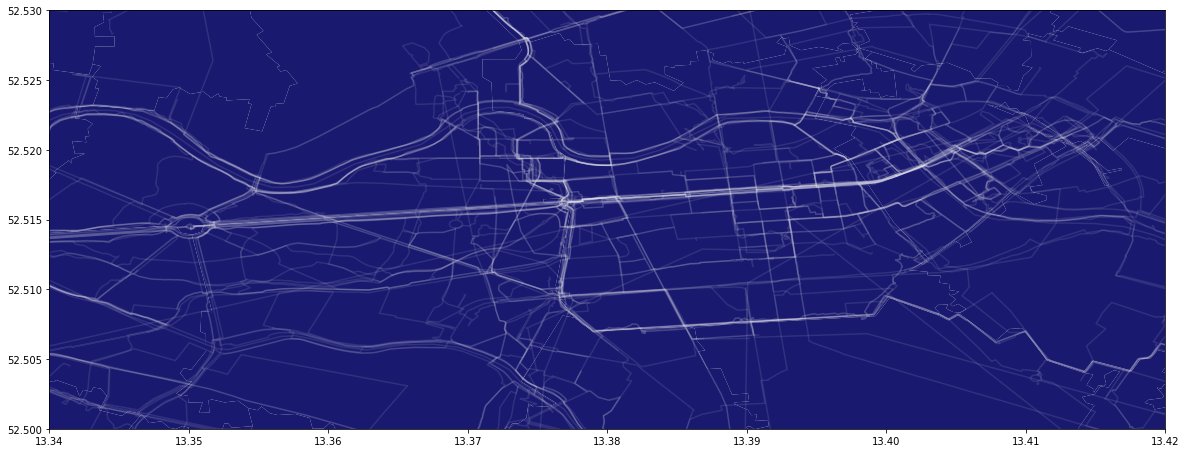

In [14]:
# Zooming in near Brandenburg Gate
fig, ax = plt.subplots(figsize=(20,8))
gdf_berlin.plot(ax=ax, color='midnightblue')
gdf_routesunique.plot(ax=ax, color='white', alpha=0.1)
ax.set_xlim(13.34, 13.42) # restricting the shown longitudes
ax.set_ylim(52.5, 52.53) # restricting the shown latitudes

We can see that several routes pass along Unter den Linden and Straße des 17. Juni.

Statistical Exploration
---

The median amount of points of interest per route in our joined dataframe is: 62.0


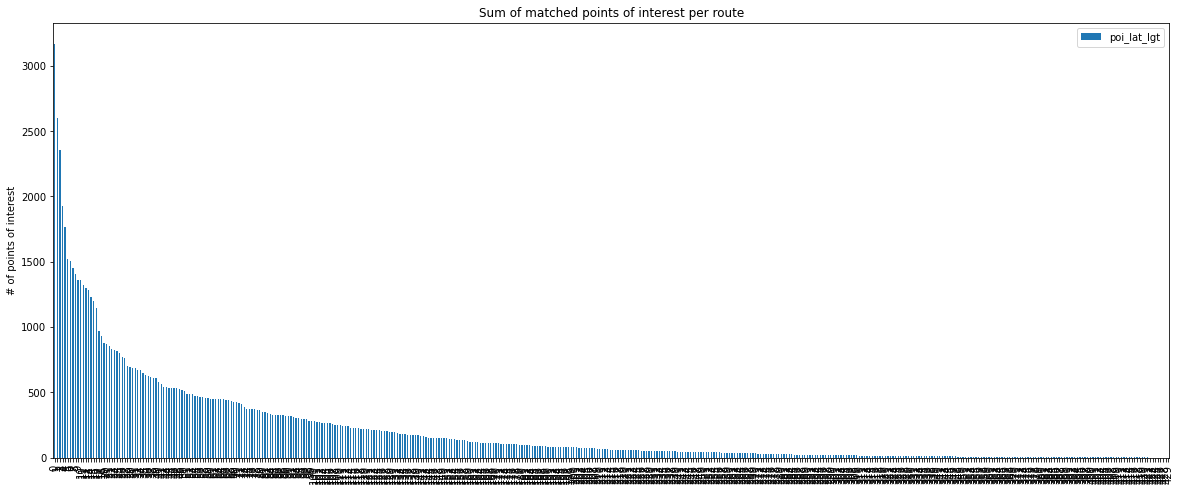

In [15]:
# Summarising the matching points of interest per each route
gdf_poiperroute = df_joineddata.groupby(by='route_id').agg({'poi_lat_lgt':'count'}).reset_index().sort_values(by='poi_lat_lgt', ascending=False)
barplot = gdf_poiperroute.plot.bar(
    x='route_id', 
    xlabel = 'routes', 
    ylabel = '# of points of interest', 
    title='Sum of matched points of interest per route', 
    use_index=False,
    figsize=(20,8)
    )
print('The median amount of points of interest per route in our joined dataframe is:', gdf_poiperroute['poi_lat_lgt'].median())

The plot shows that the points of interest are unevenly distribed along the routes with extremes on both ends. We can see that half of our routes even pass by less than 62 points of interest.

Finding out about how features are distributed along the routes:

<AxesSubplot:title={'center':'Distribution of points of interest over all routes (absolute numbers)'}, ylabel='# of points of interest by category'>

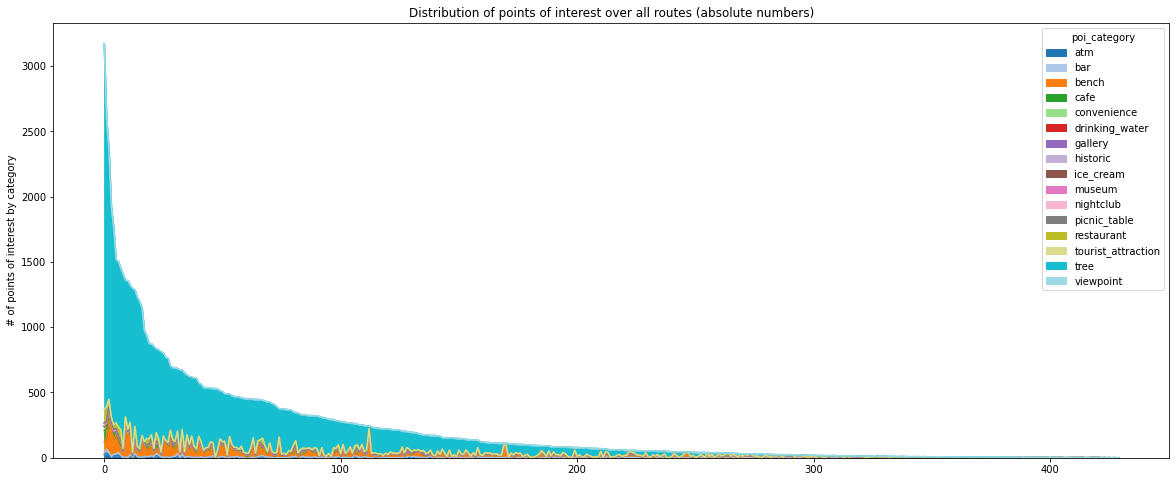

In [16]:
# Stacked bar plot to see the distributions of points of interest on all routes (absolute numbers)
columns_to_plot = ['atm', 'bar', 'bench', 'cafe', 'convenience', 'drinking_water', 'gallery', 'historic', 'ice_cream', 'museum', 'nightclub', 'picnic_table', 'restaurant', 'tourist_attraction', 'tree', 'viewpoint']
gdf_categoriesperroute = df_joineddata.groupby(by=['route_id', 'poi_category']).size().reset_index()
gdf_categoriesperroute.rename(columns={0:'count'}, inplace=True) 
gdf_categoriesperroute_wide = gdf_categoriesperroute.pivot(index='route_id', columns='poi_category', values="count")
gdf_categoriesperroute_wide['sum'] = gdf_categoriesperroute_wide.sum(axis=1, skipna=True) # new column with sum of poi per route
gdf_categoriesperroute_wide.sort_values(by='sum', ascending=False, inplace=True) # sorting by sum of poi per route
gdf_categoriesperroute_wide.plot.area(
    stacked=True,
    use_index=False,
    y = columns_to_plot,
    ylabel="# of points of interest by category",
    title="Distribution of points of interest over all routes (absolute numbers)",
    figsize=(20,8),
    colormap='tab20'
)

We can see that longer routes ('longer' interpreted as higher number of waypoints) in absolute numbers have more trees and more benches on it. Though, this graph doesn't show how points of interest (poi) are distributed percentage wise over the routes, which is probably more insightful.

<AxesSubplot:title={'center':'Distributions of points of interest over all routes (normalised)'}, ylabel='# of points of interest by category'>

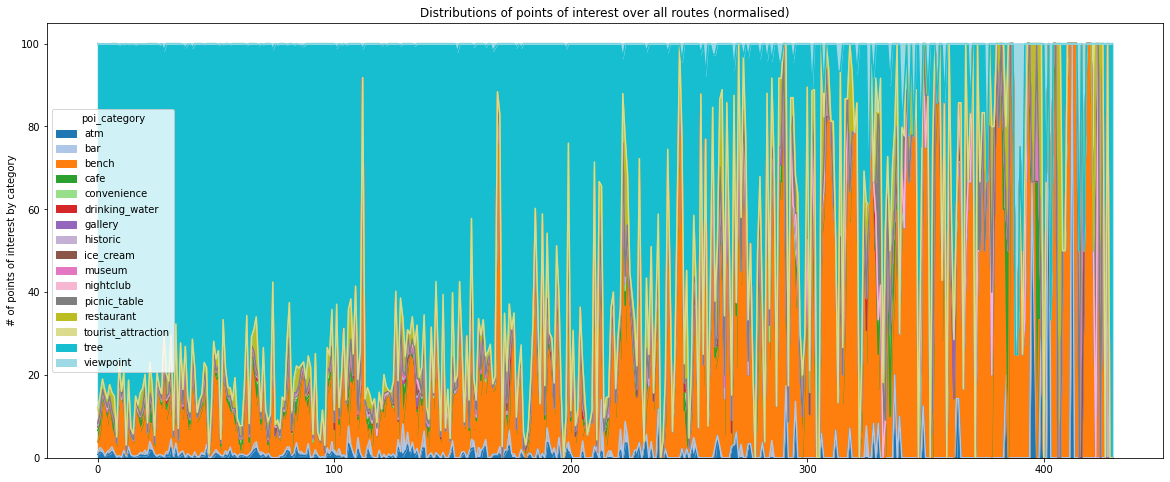

In [17]:
# Stacked bar plot to see the distribution of points of interest over all routes (normalised)
columns_to_plot = ['atm', 'bar', 'bench', 'cafe', 'convenience', 'drinking_water', 'gallery', 'historic', 'ice_cream', 'museum', 'nightclub', 'picnic_table', 'restaurant', 'tourist_attraction', 'tree', 'viewpoint']
gdf_categoriesperroute = df_joineddata.groupby(by=['route_id', 'poi_category']).size().reset_index()
gdf_categoriesperroute.rename(columns={0:'count'}, inplace=True) 
gdf_categoriesperroute_wide = gdf_categoriesperroute.pivot(index='route_id', columns='poi_category', values="count")
gdf_categoriesperroute_wide['sum'] = gdf_categoriesperroute_wide.sum(axis=1, skipna=True) # new column with sum of poi per route
gdf_categoriesperroute_wide.sort_values(by='sum', ascending=False, inplace=True) # sorting by sum of poi per route
gdf_categoriesperroute_wide = gdf_categoriesperroute_wide.apply(lambda x: 100 * x / gdf_categoriesperroute_wide['sum']) # percentages instead of absolute numbers
gdf_categoriesperroute_wide.plot.area(
    stacked=True,
    use_index=False,
    y = columns_to_plot,
    ylabel="# of points of interest by category",
    title="Distributions of points of interest over all routes (normalised)",
    figsize=(20,8),
    colormap='tab20'
)

The normalised visualisation on the distribution of points of interest on routes sorted by their lengths shows a pattern. Obviously shorter routes also have less trees along the way percentagewise.

Examining the distribition of bars (one of our features) along the routes:

<AxesSubplot:title={'center':'Distribution of bars over all routes (normalized)'}, ylabel='# of points of interest by category'>

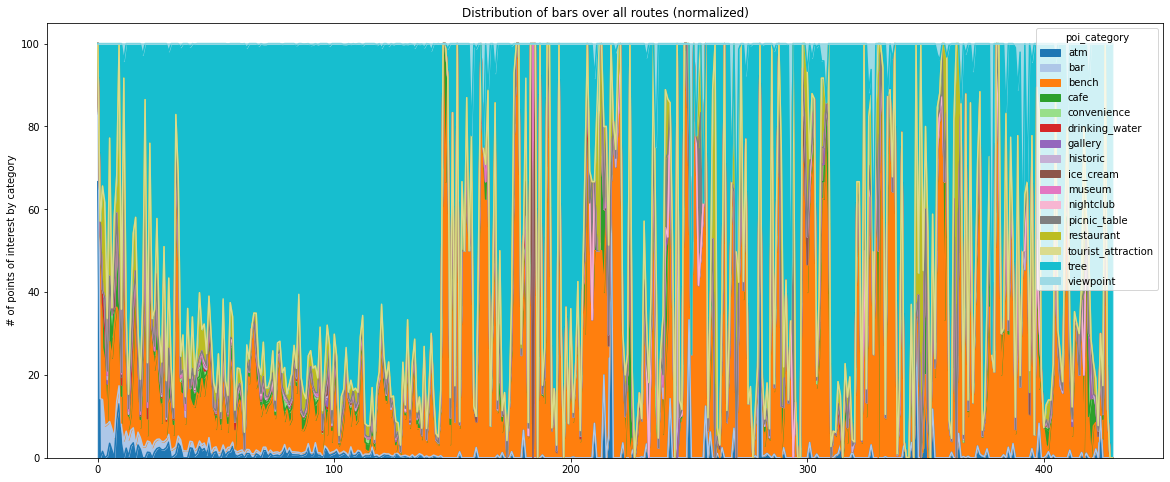

In [22]:
# Stacked bar plot by percentage of "bars" (amenity) over all routes
columns_to_plot = ['atm', 'bar', 'bench', 'cafe', 'convenience', 'drinking_water', 'gallery', 'historic', 'ice_cream', 'museum', 'nightclub', 'picnic_table', 'restaurant', 'tourist_attraction', 'tree', 'viewpoint']
gdf_categoriesperroute = df_joineddata.groupby(by=['route_id', 'poi_category']).size().reset_index()
gdf_categoriesperroute.rename(columns={0:'count'}, inplace=True) 
gdf_categoriesperroute_wide = gdf_categoriesperroute.pivot(index='route_id', columns='poi_category', values="count")
gdf_categoriesperroute_wide['sum'] = gdf_categoriesperroute_wide.sum(axis=1, skipna=True) # new column with sum of poi per route
gdf_categoriesperroute_wide = gdf_categoriesperroute_wide.apply(lambda x: 100 * x / gdf_categoriesperroute_wide['sum']) # percentages instead of absolute numbers
gdf_categoriesperroute_wide.sort_values(by='bar', ascending=False, inplace=True) # sorting by percentage of bars per route
gdf_categoriesperroute_wide.plot.area(
    stacked=True,
    use_index=False,
    y = columns_to_plot,
    ylabel="# of points of interest by category",
    title="Distribution of bars over all routes (normalized)",
    figsize=(20,8),
    colormap='tab20'
)


At first glance, bars might correlate positively with atms and with trees (surprisingly) and negatively correlate with benches, though a scatterplot would be needed to examen this further.

Examining if some features are correlated
---

In [18]:
# Reading in poicount data
df_poicoint = pd.read_csv(f'machine_learning\poicount.csv')
df_poicoint.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


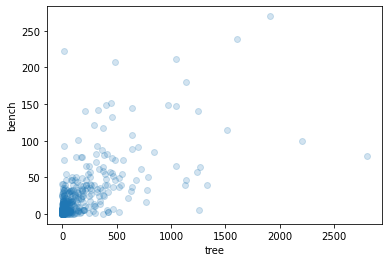

In [31]:
# First attempt: trees and benches
sns.regplot(x="tree", y="bench", data=df_poicoint, fit_reg=False, scatter_kws={"alpha": 0.2});

That's not very helpful. We need the pearson correlation calculated:

Text(50, 48, 'r = 0.63')

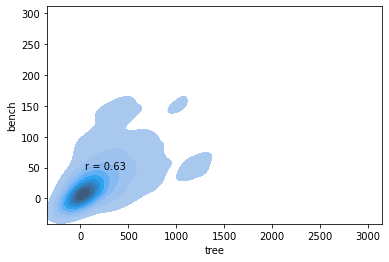

In [34]:
# Correlation of trees and benches along the same routes
r = "r = " + str(round(pearsonr(df_poicoint['tree'], df_poicoint['bench'])[0], 2))
sns.kdeplot(data=df_poicoint, x='tree', y='bench', fill=True).annotate(r, xy=(50,48), xycoords="data")

The pearson correlation is 0.63, so the occurance of trees and benches along the same route is moderately strong correlated. (That doesn't disclose too much, since longer routes simply might pass by more of each.)

Text(50, 48, 'r = 0.82')

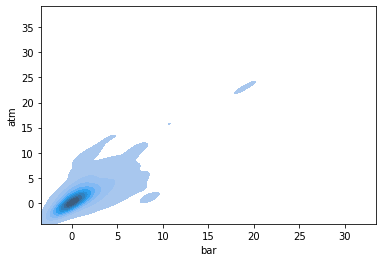

In [35]:
# Correlation of bars and atms along the same routes
r = "r = " + str(round(pearsonr(df_poicoint['bar'], df_poicoint['atm'])[0], 2))
sns.kdeplot(data=df_poicoint, x='bar', y='atm', fill=True).annotate(r, xy=(50,48), xycoords="data")

The occurance of bars and atms along the same routes is strongly correlated. (That doesn't disclose too much, since longer routes simply might pass by more of each.)

Text(50, 48, 'r = 0.43')

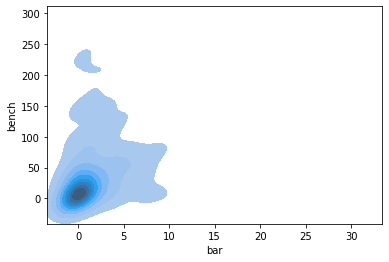

In [36]:
# Correlation of bars and benches along the same routes
r = "r = " + str(round(pearsonr(df_poicoint['bar'], df_poicoint['bench'])[0], 2))
sns.kdeplot(data=df_poicoint, x='bar', y='bench', fill=True).annotate(r, xy=(50,48), xycoords="data")

The occurance of bars and benches along the same routes is mildly correlated.  (That doesn't disclose too much, since longer routes simply might pass by more of each.)

Further Data Exploration after Clustering
---

Plotting 3D visualisations of some positively correlated features from clusters

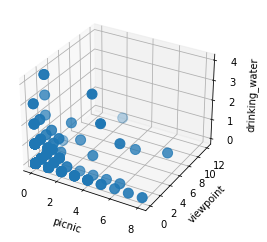

In [25]:
# Referring to the cluster with exceptionally many picnic tables, viewpoints and drinking_water
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df_poicoint['picnic'], df_poicoint['viewpoint'], df_poicoint['drinking_water'], marker = 'o', s=100)
ax.set_xlabel('picnic')
ax.set_ylabel('viewpoint')
ax.set_zlabel('drinking_water')
plt.show()

The visualisation shows interestingly regular intervals between occurence of the features. (I don't know what to make of it yet.)

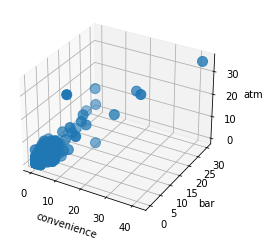

In [28]:
# Referring to the cluster with exceptionally many: convenience shops, bars and atms
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df_poicoint['convenience'], df_poicoint['bar'], df_poicoint['atm'], marker = 'o', s=100)
ax.set_xlabel('convenience')
ax.set_ylabel('bar')
ax.set_zlabel('atm')
plt.show()

The visualisation shows that the number of convenience shops isn't correlated with the number of bars along the same route.

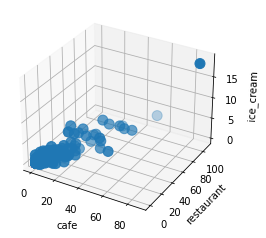

In [27]:
# Referring to the cluster with exceptionally many: cafe, restaurants and ice creame shops
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df_poicoint['cafe'], df_poicoint['restaurant'], df_poicoint['ice_cream'], marker = 'o', s=100)
ax.set_xlabel('cafe')
ax.set_ylabel('restaurant')
ax.set_zlabel('ice_cream')
plt.show()

The visualisation shows that as the number of restaurants on a route rises, so does the number of cafes. (That doesn't disclose too much, since longer routes simply might pass by more of each.)